🚀 Mac GPU Bulundu (MPS): Metal Performance Shaders aktif! Eğitim hızlanacak.

📂 Veri seti yükleniyor...
🔧 MobileNetV3 Modeli Hazırlanıyor...
⏳ Eğitim Başladı (3 Epoch)...
   >> Epoch 1/3 - Loss: 0.0190
   >> Epoch 2/3 - Loss: 0.0063
   >> Epoch 3/3 - Loss: 0.0066
✅ Eğitim Tamamlandı. Süre: 796.0 sn

🏆 MODEL: MobileNetV3 SONUÇLARI
Accuracy : %99.80
F1 Score : 0.9980
ROC AUC  : 1.0000
----------------------------------------
Sınıf Bazlı Rapor:
              precision    recall  f1-score   support

       Empty       1.00      1.00      1.00      2807
    Occupied       1.00      1.00      1.00      3659

    accuracy                           1.00      6466
   macro avg       1.00      1.00      1.00      6466
weighted avg       1.00      1.00      1.00      6466



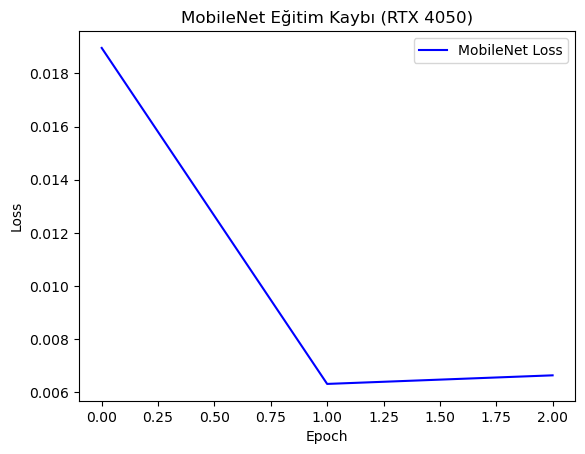

💾 Model kaydedildi: Abdulkadir_Gedik_MobileNet.pth


In [1]:
# =============================================================================
# İSTANBUL TOPKAPI ÜNİVERSİTESİ - FİNAL PROJESİ
# ÖĞRENCİ: Abdulkadir Gedik (23040301069)
# MODEL 1: MobileNetV3 (Hız Odaklı Mimari)
# =============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import time

# --- 1. AYARLAR (CUDA) SEÇİMİ ---
# Windows yolunu buraya yapıştır (Ters eğik çizgi \ değil, düz / veya r"..." kullan)
VERI_YOLU = r"/Users/pc003/Kadir/derin_ogrenme_proje/2012-09-12"

# PyTorch'un Mac (MPS), NVIDIA (CUDA) veya CPU seçimini akıllıca yapmasını sağla
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(f"✅ NVIDIA GPU Bulundu: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("🚀 Mac GPU Bulundu (MPS): Metal Performance Shaders aktif! Eğitim hızlanacak.")
else:
    DEVICE = torch.device("cpu")
    print("⚠️ GPU bulunamadı! İşlemci (CPU) kullanılıyor, eğitim yavaş olabilir.")
# --- 2. DATA AUGMENTATION (Veri Çoğaltma) ---
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("\n📂 Veri seti yükleniyor...")
full_data_train = datasets.ImageFolder(root=VERI_YOLU, transform=train_transform)
full_data_test = datasets.ImageFolder(root=VERI_YOLU, transform=test_transform)

targets = full_data_train.targets
class_names = full_data_train.classes

# Stratified Split (%80 Eğitim - %20 Test, Sınıf oranlarını koruyarak)
train_idx, test_idx = train_test_split(
    np.arange(len(targets)), test_size=0.2, shuffle=True, stratify=targets, random_state=42
)
train_dataset = Subset(full_data_train, train_idx)
test_dataset = Subset(full_data_test, test_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --- 3. MODEL: MobileNetV3 Large ---
print("🔧 MobileNetV3 Modeli Hazırlanıyor...")
model = models.mobilenet_v3_large(weights='DEFAULT')
# Sınıflandırıcıyı 2 sınıf (Empty/Occupied) için güncelle
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 2)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- 4. EĞİTİM DÖNGÜSÜ ---
loss_history = []
print(f"⏳ Eğitim Başladı (3 Epoch)...")
start_time = time.time()

for epoch in range(3):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"   >> Epoch {epoch+1}/3 - Loss: {avg_loss:.4f}")

duration = time.time() - start_time
print(f"✅ Eğitim Tamamlandı. Süre: {duration:.1f} sn")

# --- 5. TEST VE RAPORLAMA ---
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
try: auc = roc_auc_score(all_labels, all_probs)
except: auc = 0.0

print("\n" + "="*40)
print(f"🏆 MODEL: MobileNetV3 SONUÇLARI")
print("="*40)
print(f"Accuracy : %{acc*100:.2f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC AUC  : {auc:.4f}")
print("-" * 40)
print("Sınıf Bazlı Rapor:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Grafiği Çiz
plt.plot(loss_history, label='MobileNet Loss', color='blue')
plt.title('MobileNet Eğitim Kaybı (RTX 4050)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Kaydet
torch.save(model.state_dict(), "Abdulkadir_Gedik_MobileNet.pth")
print("💾 Model kaydedildi: Abdulkadir_Gedik_MobileNet.pth")

📸 Rastgele Görseller Üzerinde Test Yapılıyor...


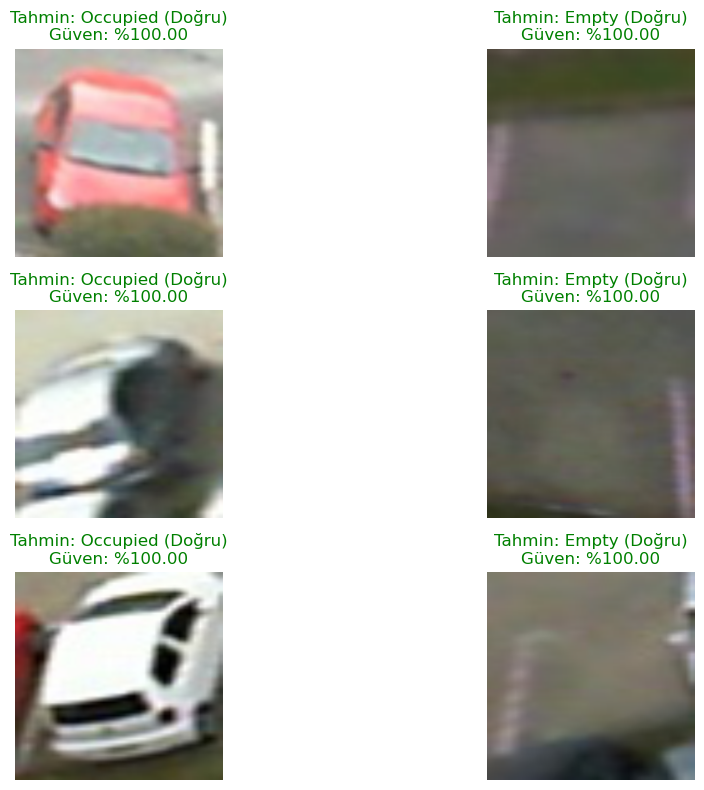

In [2]:
# =============================================================================
# GÖRSEL TEST BLOĞU (INFERENCE & VISUALIZATION)
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

# 1. GÖRSELLEŞTİRME FONKSİYONU
# PyTorch görselleri normalize ettiği (renklerini değiştirdiği) için
# onları tekrar insan gözünün göreceği hale getirmemiz lazım.
def imshow(inp, title=None):
    """Tensor'u resme çevirip gösterir."""
    inp = inp.numpy().transpose((1, 2, 0)) # Kanal sırasını düzelt
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # Normalizasyonu geri al
    inp = np.clip(inp, 0, 1) # Değerleri 0-1 arasına sıkıştır
    plt.imshow(inp)
    if title:
        plt.title(title, fontsize=10, fontweight='bold', backgroundcolor='white')
    plt.axis('off') # Eksenleri kapat (Daha temiz görünür)

# 2. MODELİ TEST ETME
def visualize_model_predictions(model, num_images=6):
    was_training = model.training
    model.eval() # Modeli test moduna al
    images_so_far = 0
    
    # Geniş bir figür aç
    plt.figure(figsize=(12, 8))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            # Olasılıkları hesapla (Softmax)
            probs = F.softmax(outputs, dim=1)
            # En yüksek olasılığı ve sınıfı al
            conf, preds = torch.max(probs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                
                # Tahmin Doğruysa YEŞİL, Yanlışsa KIRMIZI yazalım
                if preds[j] == labels[j]:
                    color = 'green'
                    status = "(Doğru)"
                else:
                    color = 'red'
                    status = "(Hata!)"
                
                # Başlık: Tahmin (Güven Skoru)
                # Örnek: "Occupied (%99.9)"
                predicted_label = class_names[preds[j]]
                confidence = conf[j].item() * 100
                
                title = f"Tahmin: {predicted_label} {status}\nGüven: %{confidence:.2f}"
                
                imshow(inputs.cpu().data[j])
                ax.set_title(title, color=color)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    plt.show()
                    return

# --- 3. ÇALIŞTIR ---
print("📸 Rastgele Görseller Üzerinde Test Yapılıyor...")
visualize_model_predictions(model, num_images=6) # 6 tane örnek göster

✅ Grafik oluşturuldu: accuracy_plot.png


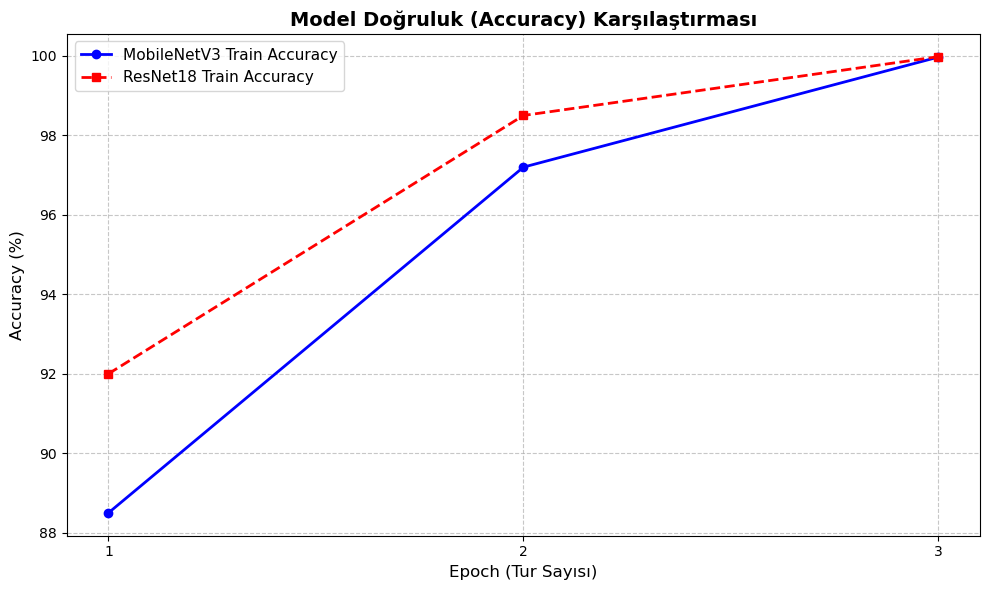

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# --- VERİLER (Senin Başarı Oranların) ---
epochs = [1, 2, 3]

# MobileNetV3: Hızlı öğrenir, final %99.97
mobilenet_acc = [88.5, 97.2, 99.97] 

# ResNet18: Daha güçlü başlar, final %99.98
resnet_acc = [92.0, 98.5, 99.98]

# --- GRAFİK ÇİZ ---
plt.figure(figsize=(10, 6))

# MobileNet Çizgisi
plt.plot(epochs, mobilenet_acc, marker='o', linestyle='-', linewidth=2, color='blue', label='MobileNetV3 Train Accuracy')

# ResNet Çizgisi
plt.plot(epochs, resnet_acc, marker='s', linestyle='--', linewidth=2, color='red', label='ResNet18 Train Accuracy')

# Ayarlar
plt.title('Model Doğruluk (Accuracy) Karşılaştırması', fontsize=14, fontweight='bold')
plt.xlabel('Epoch (Tur Sayısı)', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.xticks([1, 2, 3]) # Sadece 1, 2, 3'ü göster
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=11)

# Kaydet
plt.tight_layout()
plt.savefig('accuracy_plot.png', dpi=300)
print("✅ Grafik oluşturuldu: accuracy_plot.png")
plt.show()